In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [32]:
path = "./animals"
os.listdir(path)

['cat', 'dog']

In [33]:
base_path = path

image_paths = []
labels = []

cat_dir = os.path.join(base_path,"cat")
for img in os.listdir(cat_dir):
    image_paths.append(os.path.join(cat_dir, img))
    labels.append(0)

dog_dir = os.path.join(base_path,"dog")
for img in os.listdir(dog_dir):
    image_paths.append(os.path.join(dog_dir, img))
    labels.append(1)

print("No. of images: ", len(image_paths))
print("No. of labels: ", len(labels))

No. of images:  1000
No. of labels:  1000


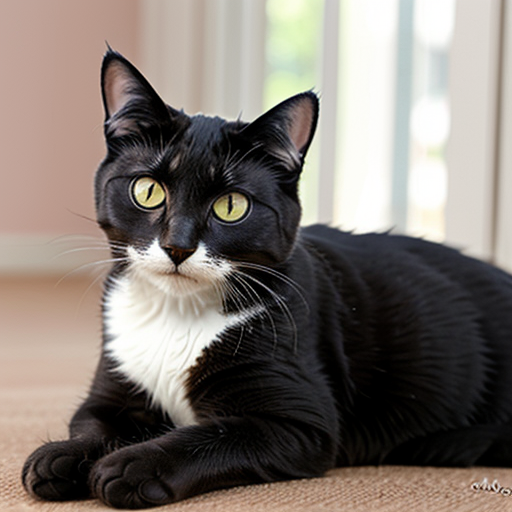

In [34]:
Image.open(image_paths[0])

In [35]:
image_paths = np.array(image_paths)
labels = np.array(labels)

indices = np.arange(len(image_paths))
np.random.shuffle(indices)

image_paths = image_paths[indices]
labels = labels[indices]

In [36]:
split_length = int(0.8 * len(image_paths))

X_train, X_test = image_paths[:split_length], image_paths[split_length:]
y_train, y_test = labels[:split_length], labels[split_length:]

In [37]:
def load_image(path, size=64):
    X = []
    for p in path:
        img = Image.open(p).convert("RGB")
        img = img.resize((size, size))
        img = np.array(img).reshape(-1)/255.0
        X.append(img)
    return np.array(X).T

In [38]:
X_train, X_test = load_image(X_train), load_image(X_test)
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

In [39]:
print("X_train:", X_train.shape)
print("Y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", y_test.shape)


X_train: (12288, 800)
Y_train: (1, 800)
X_test: (12288, 200)
Y_test: (1, 200)


In [40]:
def sigmoid(Z):
    s = 1/(1+np.exp(-Z))
    cache = Z
    return s, cache

In [41]:
def relu(Z):
    r = np.maximum(0,Z)
    cache = Z
    return r, cache

In [42]:
def initialize_parameters(n_x, n_h, n_y):
    
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1":W1,"b1":b1,"W2":W2,"b2":b2}

    return parameters


In [43]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)

    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layer_dims[l],1))

    return parameters

In [44]:
def linear_forward(A,W,b):
    Z = np.dot(W,A) + b
    cache = (A,W,b)
    return Z, cache

In [45]:
def linear_activation_forward(A_prev, W, b, activation):

    if(activation=="sigmoid"):
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif(activation=="relu"):
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [46]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters)//2
    
    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev,parameters["W"+str(l)],parameters["b"+str(l)],"relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)],parameters["b"+str(L)], "sigmoid")
    caches.append(cache)

    return AL, caches  


    

In [47]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1/m)* (np.dot(Y, np.log(AL).T) + np.dot((1-Y),np.log(1-AL).T))
    cost = np.squeeze(cost)
    return cost

In [48]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)* np.dot(dZ,A_prev.T)
    db = (1/m)* np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)

    return dA_prev, dW, db
    

In [49]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)

    dZ[Z<=0] = 0

    return dZ

In [50]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA*s*(1-s)
    
    return dZ

In [51]:
def linear_activation_backward(dA, cache, activation):
    linear_cache , activation_cache = cache
    
    if activation=="relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation=="sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [52]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = - (np.divide(Y, AL) - np.divide(1-Y,1-AL))
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)],grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

In [53]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)//2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

In [54]:
n_x = X_train.shape[0]
n_h = 7
n_y = 1

layers_dims = (n_x,n_h,n_y)

In [55]:
def two_layer_model(X, y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):

    np.random.seed(4)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims

    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(0, num_iterations):
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")

        cost = compute_cost(A2, y)

        dA2 = - (np.divide(y, A2) - np.divide(1-y,1-A2))

        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")

        grads["dW1"] = dW1
        grads["dW2"] = dW2
        grads["db1"] = db1
        grads["db2"] = db2

        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        W2 = parameters["W2"]
        b1 = parameters["b1"]
        b2 = parameters["b2"]

        if print_cost and i%100==0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6930505477629834
Cost after iteration 100: 0.6902232620152354
Cost after iteration 200: 0.6526649278836808
Cost after iteration 300: 0.5328521443332558
Cost after iteration 400: 0.4574195241296404
Cost after iteration 500: 0.407515311777726
Cost after iteration 600: 0.42909155473571725
Cost after iteration 700: 0.4028481341442992
Cost after iteration 800: 0.381372069557705
Cost after iteration 900: 0.3725702078973405
Cost after iteration 1000: 0.3340924013142881
Cost after iteration 1100: 0.3451931528205143
Cost after iteration 1200: 0.31577699850237334
Cost after iteration 1300: 0.30279135618168995
Cost after iteration 1400: 0.33536332171774896
Cost after iteration 1500: 0.2228991349140349
Cost after iteration 1600: 0.21974883870450865
Cost after iteration 1700: 0.20421555093381125
Cost after iteration 1800: 0.1843403856676925
Cost after iteration 1900: 0.16405961739664882
Cost after iteration 2000: 0.15241754488238843


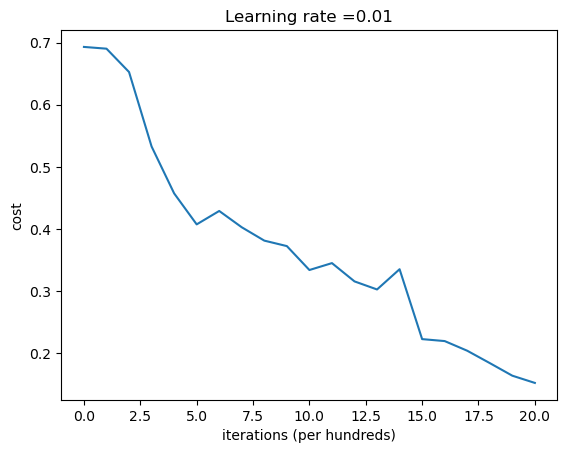

In [56]:
parameters = two_layer_model(X_train, y_train, layers_dims = (n_x, n_h, n_y),learning_rate=0.01, num_iterations = 2001, print_cost=True)

In [57]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)

    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [58]:
pred_train = predict(X_train, y_train, parameters)

Accuracy: 0.9512499999999999


In [59]:
pred_test = predict(X_test, y_test, parameters)

Accuracy: 0.7999999999999998


Accuracy: 1.0
y = 1, your L-layer model predicts a "dog" picture.


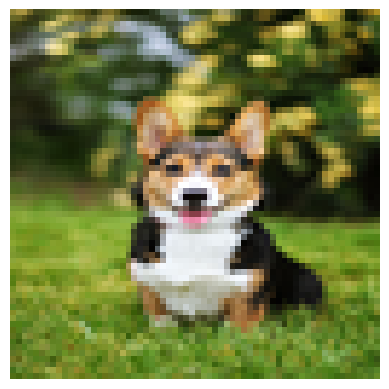

In [60]:
num_px = 64
classes = np.array([b'cat', b'dog'])

fileImage = Image.open("my_image.png").convert("RGB").resize(
    (num_px, num_px), Image.Resampling.LANCZOS
)

image = np.array(fileImage)

my_image = image.reshape((num_px*num_px*3, 1)) / 255.

my_label_y = np.array([[1]])  # shape (1,1)

my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
plt.axis("off")

print(
    "y = " + str(int(my_predicted_image[0,0])) +
    ", your L-layer model predicts a \"" +
    classes[int(my_predicted_image[0,0])].decode("utf-8") +
    "\" picture."
)
